<a href="https://colab.research.google.com/github/chorltonm/fa-cup-upsets/blob/main/notebooks/models/logistic_regression_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import general python libaries
import os
import json
import pandas as pd
import numpy as np
import importlib

# Google Cloud libraries
from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import drive
from google.colab import userdata

# Scikit Learn libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from matplotlib import pyplot
import seaborn as sns




In [3]:
# Mount Google Drive
drive.mount('/content/drive')

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/python_files')



Mounted at /content/drive


In [4]:
# Authentication credentials and keys

# Google Service Account

# Load the JSON key from local Google Collab file
key = json.load(open('/content/drive/MyDrive/service_account.json', 'r'))

# Authenticate using the loaded key
credentials = service_account.Credentials.from_service_account_info(key)

# Set up the BigQuery client with the credentials to project
client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

In [18]:
# Feature Data

fa_cup_raw_features = """
    select * from preparation_layer.view_fa_cup_round_3_features
"""

fa_cup_raw_features_df = client.query(fa_cup_raw_features).to_dataframe()
display(fa_cup_raw_features_df[['arena_stadium_capacity', 'match_weather_data_hours_condition']])


,arena_stadium_capacity,match_weather_data_hours_condition
0,41837,
1,41837,Overcast
2,41837,Partially cloudy
3,74879,Partially cloudy
4,74879,
...,...,...
300,2150,"Overcast Rain, Partially cloudy"
301,<NA>,
302,9527,Overcast Partially cloudy
303,6064,Overcast


In [ ]:
def data_preprocessing (train_data);

  # Update missing category values for weather category with the mode
  column_name = 'match_weather_data_hours_condition'
  mode_value = train_data[column_name].mode().iloc[0]
  train_data[column_name] = train_data[column_name] = train_data[column_name].fillna(mode_value)

  # Update missign values
  missing_values = [var for var in train_data.columns if train_data[var].isnull().sum() > 0]
  median_missing_values = train_data[missing_vValues].median().to_dict()
  train_data.fillna(median_missing_values inplace=True)

  # Update outlier on areana data
  train_data.loc[train_data['arena_stadium_capacity'] > max_value, 'arena_stadium_capacity'] = max_value

  # Encode categorical values
  # Initialize OneHotEncoder
  encoder = OneHotEncoder(sparse_output=False)
  categorical_columns = train_data.select_dtypes(include=['object']).columns.tolist()

  # Apply one-hot encoding to the categorical columns
  one_hot_encoded = encoder.fit_transform(train_data[categorical_columns])

  #Create a DataFrame with the one-hot encoded columns
  # Use get_feature_names_out() to get the column names for the encoded data
  one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

  # Concatenate the one-hot encoded dataframe with the original dataframe
  concat_df = pd.concat([train_data, one_hot_encoded_df], axis=1)

  # Drop the original categorical columns and moe target variable to the end.
  train_data = concat_df.drop(categorical_columns, axis=1)
  target_variable_column = train_data.pop('target_variable')
  train_data.insert(len(train_data.columns),'target_variable',target_variable_column )

  return(train_data)

In [ ]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Select the columns to normalize
columns_to_normalize = [
    'arena_stadium_capacity',
    'home_team_round_3_position',
    'home_team_massey',
    'home_team_colley',
    'home_team_keener',
    'home_team_trueskill',
    'home_team_borda_count',
    'home_team_local_kemeny_optimisation',
    'away_team_round_3_position',
    'away_team_massey',
    'away_team_colley',
    'away_team_keener',
    'away_team_trueskill',
    'away_team_borda_count',
    'away_team_local_kemeny_optimisation',
    'match_weather_data_hours_feelslike',
    'match_weather_data_hours_humidity',
    'match_weather_data_hours_dew',
    'match_weather_data_hours_precip',
    'match_weather_data_hours_snow',
    'match_weather_data_hours_snowdepth',
    'match_weather_data_hours_windspeed',
    'match_weather_data_hours_pressure',
    'match_weather_data_hours_visibility',
    'match_weather_data_hours_cloudcover'
]

# Create a MinMaxScaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the selected columns
normalized_data = scaler.fit_transform(df_encoded[columns_to_normalize])

# Create a new dataframe with the normalized data
normalized_df = pd.DataFrame(normalized_data, columns=columns_to_normalize, index=fa_cup_cleaned_features_df.index)

# Replace the original columns with the normalized values
df_encoded[columns_to_normalize] = normalized_df

# Print the first few rows to verify the changes
display(df_encoded)

# You can also check the summary statistics to confirm the normalization
display(fa_cup_cleaned_features_df[columns_to_normalize].describe())



,arena_stadium_capacity,home_team_round_3_position,home_team_massey,home_team_colley,home_team_keener,home_team_trueskill,home_team_borda_count,home_team_local_kemeny_optimisation,home_lineup_strength,home_team_league_form,...,match_weather_data_hours_condition_Partially cloudy,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",target_variable
0,0.682963,0.000000,0.000000,0.000000,0.174603,0.000000,0.000000,0.000000,0.80,0.72,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.682963,0.000000,0.000000,0.000000,0.174603,0.000000,0.000000,0.000000,0.82,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.682963,0.000000,0.000000,0.000000,0.174603,0.000000,0.000000,0.000000,0.88,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1.000000,0.000000,0.000000,0.000000,0.174603,0.000000,0.000000,0.000000,0.82,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1.000000,0.015873,0.031746,0.095238,0.047619,0.079365,0.063492,0.063492,0.80,0.67,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,0.405266,1.000000,0.904762,1.000000,0.825397,0.984127,1.000000,1.000000,0.80,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
301,0.405266,1.000000,0.904762,1.000000,0.825397,0.984127,1.000000,1.000000,0.80,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
302,0.126949,1.000000,0.904762,1.000000,0.825397,0.984127,1.000000,1.000000,0.90,0.22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
303,0.067355,1.000000,0.904762,1.000000,0.825397,0.984127,1.000000,1.000000,0.15,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


,arena_stadium_capacity,home_team_round_3_position,home_team_massey,home_team_colley,home_team_keener,home_team_trueskill,home_team_borda_count,home_team_local_kemeny_optimisation,away_team_round_3_position,away_team_massey,...,match_weather_data_hours_feelslike,match_weather_data_hours_humidity,match_weather_data_hours_dew,match_weather_data_hours_precip,match_weather_data_hours_snow,match_weather_data_hours_snowdepth,match_weather_data_hours_windspeed,match_weather_data_hours_pressure,match_weather_data_hours_visibility,match_weather_data_hours_cloudcover
count,305.0,305.0,305.0,305.0,305.0,305.0,305.0,305.0,305.0,305.0,...,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000
mean,26996.901639,32.957377,31.186885,30.881967,31.042623,30.754098,31.386885,31.354098,35.986885,35.390164,...,39.615000,81.705008,38.300984,0.000141,0.000197,0.130639,9.728525,1018.005082,11.423115,65.175902
std,15105.095407,19.815966,19.114987,18.935812,19.51909,18.758556,19.469303,19.48496,18.014244,17.862097,...,14.590771,12.869971,11.424452,0.000881,0.002137,0.686505,4.988857,14.212158,5.890923,28.689887
min,2150.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-8.600000,21.755000,-8.500000,0.000000,0.000000,0.000000,0.400000,982.050000,0.550000,0.000000
25%,15231.0,14.0,14.0,15.0,14.0,15.0,14.0,14.0,21.0,21.0,...,31.900000,75.405000,32.950000,0.000000,0.000000,0.000000,6.000000,1011.200000,7.100000,46.200000
50%,25700.0,33.0,30.0,29.0,29.0,30.0,29.0,29.0,37.0,37.0,...,37.275000,84.647500,37.300000,0.000000,0.000000,0.000000,9.100000,1020.350000,9.900000,72.200000
75%,33597.0,51.0,49.0,48.0,49.0,47.0,50.0,50.0,52.0,51.0,...,42.850000,90.200000,42.700000,0.000000,0.000000,0.000000,12.100000,1028.600000,15.250000,89.600000
max,60260.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,...,93.250000,99.955000,75.600000,0.011000,0.030000,9.895000,29.550000,1041.550000,30.850000,100.000000


In [ ]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Select the columns to normalize
columns_to_normalize = [
    'arena_stadium_capacity',
    'home_team_round_3_position',
    'home_team_massey',
    'home_team_colley',
    'home_team_keener',
    'home_team_trueskill',
    'home_team_borda_count',
    'home_team_local_kemeny_optimisation',
    'away_team_round_3_position',
    'away_team_massey',
    'away_team_colley',
    'away_team_keener',
    'away_team_trueskill',
    'away_team_borda_count',
    'away_team_local_kemeny_optimisation',
    'match_weather_data_hours_feelslike',
    'match_weather_data_hours_humidity',
    'match_weather_data_hours_dew',
    'match_weather_data_hours_precip',
    'match_weather_data_hours_snow',
    'match_weather_data_hours_snowdepth',
    'match_weather_data_hours_windspeed',
    'match_weather_data_hours_pressure',
    'match_weather_data_hours_visibility',
    'match_weather_data_hours_cloudcover'
]

# Create a MinMaxScaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the selected columns
normalized_data = scaler.fit_transform(df_encoded[columns_to_normalize])

# Create a new dataframe with the normalized data
normalized_df = pd.DataFrame(normalized_data, columns=columns_to_normalize, index=fa_cup_cleaned_features_df.index)

# Replace the original columns with the normalized values
df_encoded[columns_to_normalize] = normalized_df

# Print the first few rows to verify the changes
display(df_encoded)

# You can also check the summary statistics to confirm the normalization
display(fa_cup_cleaned_features_df[columns_to_normalize].describe())



,arena_stadium_capacity,home_team_round_3_position,home_team_massey,home_team_colley,home_team_keener,home_team_trueskill,home_team_borda_count,home_team_local_kemeny_optimisation,home_lineup_strength,home_team_league_form,...,match_weather_data_hours_condition_Partially cloudy,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",target_variable
0,0.682963,0.000000,0.000000,0.000000,0.174603,0.000000,0.000000,0.000000,0.80,0.72,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.682963,0.000000,0.000000,0.000000,0.174603,0.000000,0.000000,0.000000,0.82,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.682963,0.000000,0.000000,0.000000,0.174603,0.000000,0.000000,0.000000,0.88,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1.000000,0.000000,0.000000,0.000000,0.174603,0.000000,0.000000,0.000000,0.82,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1.000000,0.015873,0.031746,0.095238,0.047619,0.079365,0.063492,0.063492,0.80,0.67,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,0.405266,1.000000,0.904762,1.000000,0.825397,0.984127,1.000000,1.000000,0.80,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
301,0.405266,1.000000,0.904762,1.000000,0.825397,0.984127,1.000000,1.000000,0.80,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
302,0.126949,1.000000,0.904762,1.000000,0.825397,0.984127,1.000000,1.000000,0.90,0.22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
303,0.067355,1.000000,0.904762,1.000000,0.825397,0.984127,1.000000,1.000000,0.15,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


,arena_stadium_capacity,home_team_round_3_position,home_team_massey,home_team_colley,home_team_keener,home_team_trueskill,home_team_borda_count,home_team_local_kemeny_optimisation,away_team_round_3_position,away_team_massey,...,match_weather_data_hours_feelslike,match_weather_data_hours_humidity,match_weather_data_hours_dew,match_weather_data_hours_precip,match_weather_data_hours_snow,match_weather_data_hours_snowdepth,match_weather_data_hours_windspeed,match_weather_data_hours_pressure,match_weather_data_hours_visibility,match_weather_data_hours_cloudcover
count,305.0,305.0,305.0,305.0,305.0,305.0,305.0,305.0,305.0,305.0,...,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000
mean,26996.901639,32.957377,31.186885,30.881967,31.042623,30.754098,31.386885,31.354098,35.986885,35.390164,...,39.615000,81.705008,38.300984,0.000141,0.000197,0.130639,9.728525,1018.005082,11.423115,65.175902
std,15105.095407,19.815966,19.114987,18.935812,19.51909,18.758556,19.469303,19.48496,18.014244,17.862097,...,14.590771,12.869971,11.424452,0.000881,0.002137,0.686505,4.988857,14.212158,5.890923,28.689887
min,2150.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-8.600000,21.755000,-8.500000,0.000000,0.000000,0.000000,0.400000,982.050000,0.550000,0.000000
25%,15231.0,14.0,14.0,15.0,14.0,15.0,14.0,14.0,21.0,21.0,...,31.900000,75.405000,32.950000,0.000000,0.000000,0.000000,6.000000,1011.200000,7.100000,46.200000
50%,25700.0,33.0,30.0,29.0,29.0,30.0,29.0,29.0,37.0,37.0,...,37.275000,84.647500,37.300000,0.000000,0.000000,0.000000,9.100000,1020.350000,9.900000,72.200000
75%,33597.0,51.0,49.0,48.0,49.0,47.0,50.0,50.0,52.0,51.0,...,42.850000,90.200000,42.700000,0.000000,0.000000,0.000000,12.100000,1028.600000,15.250000,89.600000
max,60260.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,64.0,...,93.250000,99.955000,75.600000,0.011000,0.030000,9.895000,29.550000,1041.550000,30.850000,100.000000


In [ ]:
features = list(df_encoded)
print(features)

correlation_matrix = df_encoded.corr()
target_correlations = correlation_matrix['target_variable'].sort_values(ascending=False)
print(target_correlations)

# plot correlation matrix
f, ax = pyplot.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)


['arena_stadium_capacity', 'home_team_round_3_position', 'home_team_massey', 'home_team_colley', 'home_team_keener', 'home_team_trueskill', 'home_team_borda_count', 'home_team_local_kemeny_optimisation', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_team_round_3_position', 'away_team_massey', 'away_team_colley', 'away_team_keener', 'away_team_trueskill', 'away_team_borda_count', 'away_team_local_kemeny_optimisation', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_data_hours_precip', 'match_weather_data_hours_snow', 'match_weather_data_hours_snowdepth', 'match_weather_data_hours_windspeed', 'match_weather_data_hours_pressure', 'match_weather_data_hours_visibility', 'match_weather_dat

In [26]:
def run_logistic_regression(df, target_column, weights=None, n_splits=5, random_state=42):

    # Create the StratifiedKFold object
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Initialize lists to store results
    accuracies = []
    confusion_matrices = []
    classification_reports = []
    all_y_true = []
    all_y_pred = []

    # Prepare the feature set
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        # Split the data
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Data preprocessing

        # Train the model
        model = LogisticRegression(class_weight=weights, max_iter=1000)
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_val)

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        accuracies.append(accuracy)

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Generate classification report
        cr = classification_report(y_val, y_pred, output_dict=True)
        classification_reports.append(cr)

        # Store true and predicted values for later analysis
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

        print(f"Fold {fold} Accuracy: {accuracy:.3f}")

    # Calculate average accuracy
    avg_accuracy = sum(accuracies) / len(accuracies)
    print(f"Average Accuracy: {avg_accuracy:.3f}")

    return all_y_true, all_y_pred, accuracies, model_name


In [27]:
# Import user defined python functions
import model_evaluation_functions
importlib.reload(model_evaluation_functions)
from model_evaluation_functions import create_model_results_df

df_all = fa_cup_raw_features_df
#display(df)

#Logistic Regresssion

# Standard, no weights
model_name = "Standard LogisticRegression"
# Define the ranking systems
ranking_systems = ['round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

# Get all columns except the target and ranking columns
base_features = [col for col in df_all.columns if not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]

# Loop through each ranking system
for ranking in ranking_systems:
        print(f"\nRunning model for {ranking} ranking system")
        model_name_ranking = model_name + ' ' + ranking
        print(model_name_ranking)
        # Prepare the feature set for the current ranking system
        current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
        df_current = df_all[current_features]
        display(df_current)
        all_y_true, all_y_pred, accuracies, model_name = run_logistic_regression(df_current, 'target_variable')
        results_df_slr = create_model_results_df(all_y_true, all_y_pred, accuracies, model_name_ranking)
        display(results_df_slr)





# Weighted by percentage unbalanced
#model_name = "Weighted LogisticRegression"

# Calculate weights based on % split of class labels (0,1)
y = df_encoded['target_variable']
class_counts = y.value_counts()
total_samples = len(y)
weights = {class_label: int(round((1 - (count / total_samples)) * 100))
           for class_label, count in class_counts.items()}
print(weights)

#all_y_true, all_y_pred, accuracies, model_name = run_logistic_regression(df_encoded, 'target_variable', weights=weights)
#results_df_wlr = create_model_results_df(all_y_true, all_y_pred, accuracies, model_name)
#display(results_df_wlr)

# Combine results dataframes
#combined_results_lr = results_df_slr.merge(results_df_wlr, on='metric')
#display(combined_results_lr)



Running model for round_3_position ranking system
Standard LogisticRegression round_3_position


,arena_stadium_capacity,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_lineup_strength,away_team_league_form,away_team_league_form_home_and_away,away_team_league_promotion_relegation,rivalry_flag,...,match_weather_data_hours_snow,match_weather_data_hours_snowdepth,match_weather_data_hours_windspeed,match_weather_data_hours_pressure,match_weather_data_hours_visibility,match_weather_data_hours_cloudcover,match_weather_data_hours_condition,target_variable,home_team_round_3_position,away_team_round_3_position
0,41837,NaN,0.72,0.50,0,NaN,0.06,0.28,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,,0,1,34
1,41837,0.82,0.00,0.56,0,0.81,0.50,0.67,0,0,...,0.0,0.00,4.80,1036.70,2.05,95.90,Overcast,0,1,25
2,41837,0.88,0.00,0.67,0,0.77,0.56,0.33,1,0,...,0.0,0.00,2.10,1031.70,4.20,87.00,Partially cloudy,0,1,48
3,74879,0.82,0.00,0.72,0,0.63,0.00,0.39,0,0,...,NaN,0.00,7.65,1015.50,5.15,67.10,Partially cloudy,0,1,25
4,74879,NaN,0.67,0.50,0,NaN,0.00,0.61,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,,1,2,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,2150,NaN,NaN,NaN,0,0.73,0.00,0.28,0,0,...,0.0,0.04,13.65,1022.25,11.80,94.85,"Overcast Rain, Partially cloudy",0,63,6
301,<NA>,NaN,NaN,NaN,0,0.74,0.56,0.50,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,,0,64,34
302,9527,0.90,0.22,0.39,0,0.67,0.67,0.50,0,0,...,0.0,0.00,14.45,1012.75,9.00,94.25,Overcast Partially cloudy,1,64,48
303,6064,0.15,NaN,NaN,0,0.74,0.33,0.44,1,0,...,0.0,0.00,6.35,1036.35,15.15,98.65,Overcast,0,64,8


ValueError: could not convert string to float: 'Overcast'

In [ ]:
def run_neural_network(df, target_column, hidden_layer_sizes=(10), features_to_drop=None, n_splits=5, random_state=42):

    # Create the StratifiedKFold object
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Initialize lists to store results
    accuracies = []
    confusion_matrices = []
    classification_reports = []
    all_y_true = []
    all_y_pred = []

    # Prepare the feature set
    X = df.drop(target_column, axis=1)
    if features_to_drop:
        X = X.drop(features_to_drop, axis=1)
    y = df[target_column]

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        # Split the data
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Train the model
        model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                              max_iter=1000,
                              random_state=random_state)

        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_val)

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        accuracies.append(accuracy)

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Generate classification report
        cr = classification_report(y_val, y_pred, output_dict=True)
        classification_reports.append(cr)

        # Store true and predicted values for later analysis
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

        print(f"Fold {fold} Accuracy: {accuracy:.3f}")

    # Calculate average accuracy
    avg_accuracy = sum(accuracies) / len(accuracies)
    print(f"Average Accuracy: {avg_accuracy:.3f}")

    return all_y_true, all_y_pred, accuracies, "Neural Network"


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 1 Accuracy: 0.738


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 2 Accuracy: 0.721


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 3 Accuracy: 0.754


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 4 Accuracy: 0.721
Fold 5 Accuracy: 0.787
Average Accuracy: 0.744


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


,metric,Standard LogisticRegression,Weighted LogisticRegression,Neural Network
0,Cross-validation Accuracy,0.738,0.564,0.744
1,Overall Accuracy,0.738,0.564,0.744
2,Confusion Matrix - True Negative (Class 0),214.000,130.000,197.000
3,Confusion Matrix - False Positive (Class 1),9.000,93.000,26.000
4,Confusion Matrix - False Negative (Class 0),71.000,40.000,52.000
5,Confusion Matrix - True Positive (Class 1),11.000,42.000,30.000
6,Precision (Class 0),0.751,0.765,0.791
7,Recall (Class 0),0.960,0.583,0.883
8,F1-score (Class 0),0.843,0.662,0.835
9,Precision (Class 1),0.550,0.311,0.536


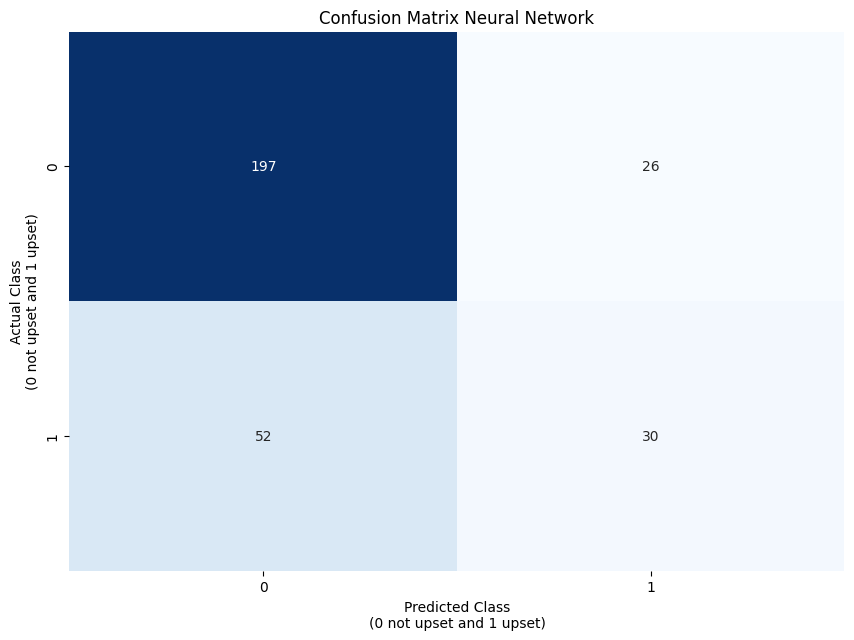

In [ ]:
# Import user defined python functions
import model_evaluation_functions
importlib.reload(model_evaluation_functions)
from model_evaluation_functions import create_model_results_df

#Logistic Regresssion

# MCP Neural Network
model_name = "MCP Classifier Neural Network"
all_y_true, all_y_pred, accuracies, model_name = run_neural_network(df_encoded, 'target_variable')
results_df_mcp_nn = create_model_results_df(all_y_true, all_y_pred, accuracies, model_name)

# Combine results dataframes
combined_results = combined_results_lr.merge(results_df_mcp_nn, on='metric')
display(combined_results)

In [6]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.linear_model import LogisticRegression

# Import user defined python functions
import model_evaluation_functions
importlib.reload(model_evaluation_functions)
from model_evaluation_functions import create_model_results_df

# Standard, no weights
model_name = "Standard LogisticRegression"
# Define the ranking systems
ranking_systems = ['round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

# Get all columns except the target and ranking columns
base_features = [col for col in fa_cup_raw_features_df.columns if not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]

# Identify numeric and categorical columns
numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ranking_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
accuracies = []
confusion_matrices = []
classification_reports = []
all_y_true = []
all_y_pred = []

# Loop through each ranking system
for ranking in ranking_systems:
    print(f"\nRunning model for {ranking} ranking system")
    model_name_ranking = f"{model_name} {ranking}"
    print(model_name_ranking)

    # Prepare the feature set for the current ranking system
    current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
    X = fa_cup_raw_features_df[current_features]
    y = fa_cup_raw_features_df['target_variable']

    # Update preprocessor with current features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            ('rank', ranking_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
        ])

    # Create pipeline
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000))
    ])

    # Perform cross-validation
    all_y_pred = cross_val_predict(model, X, y, cv=skf)
    accuracies = cross_val_score(model, X, y, cv=skf, scoring='accuracy')

    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    confusion_matrices.append(cm)

    # Generate classification report
    cr = classification_report(y_val, y_pred, output_dict=True)
    classification_reports.append(cr)

    # Store true and predicted values for later analysis
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)

    print(f"Fold {fold} Accuracy: {accuracy:.3f}")

# Calculate average accuracy
avg_accuracy = sum(accuracies) / len(accuracies)
print(f"Average Accuracy: {avg_accuracy:.3f}")


# Create and display results using your existing function
results_df_slr = create_model_results_df(y, all_y_pred, accuracies, model_name_ranking)
display(results_df_slr)





Running model for round_3_position ranking system
Standard LogisticRegression round_3_position


NameError: name 'y_val' is not defined


Running model for round_3_position ranking system
Standard LogisticRegression round_3_position

Fold 1
Fold 1 Accuracy: 0.721

Fold 2
Fold 2 Accuracy: 0.689

Fold 3
Fold 3 Accuracy: 0.721

Fold 4
Fold 4 Accuracy: 0.705

Fold 5
Fold 5 Accuracy: 0.738
Average Accuracy: 0.715


,metric,Standard LogisticRegression round_3_position
0,Cross-validation Accuracy,0.715
1,Overall Accuracy,0.715
2,Confusion Matrix - True Negative (Class 0),213.000
3,Confusion Matrix - False Positive (Class 1),10.000
4,Confusion Matrix - False Negative (Class 0),77.000
5,Confusion Matrix - True Positive (Class 1),5.000
6,Precision (Class 0),0.734
7,Recall (Class 0),0.955
8,F1-score (Class 0),0.830
9,Precision (Class 1),0.333



Running model for massey ranking system
Standard LogisticRegression massey

Fold 1
Fold 1 Accuracy: 0.754

Fold 2
Fold 2 Accuracy: 0.738

Fold 3
Fold 3 Accuracy: 0.738

Fold 4
Fold 4 Accuracy: 0.721

Fold 5
Fold 5 Accuracy: 0.738
Average Accuracy: 0.738


,metric,Standard LogisticRegression massey
0,Cross-validation Accuracy,0.738
1,Overall Accuracy,0.738
2,Confusion Matrix - True Negative (Class 0),216.000
3,Confusion Matrix - False Positive (Class 1),7.000
4,Confusion Matrix - False Negative (Class 0),73.000
5,Confusion Matrix - True Positive (Class 1),9.000
6,Precision (Class 0),0.747
7,Recall (Class 0),0.969
8,F1-score (Class 0),0.844
9,Precision (Class 1),0.562



Running model for colley ranking system
Standard LogisticRegression colley

Fold 1
Fold 1 Accuracy: 0.738

Fold 2
Fold 2 Accuracy: 0.689

Fold 3
Fold 3 Accuracy: 0.721

Fold 4
Fold 4 Accuracy: 0.754

Fold 5
Fold 5 Accuracy: 0.705
Average Accuracy: 0.721


,metric,Standard LogisticRegression colley
0,Cross-validation Accuracy,0.721
1,Overall Accuracy,0.721
2,Confusion Matrix - True Negative (Class 0),212.000
3,Confusion Matrix - False Positive (Class 1),11.000
4,Confusion Matrix - False Negative (Class 0),74.000
5,Confusion Matrix - True Positive (Class 1),8.000
6,Precision (Class 0),0.741
7,Recall (Class 0),0.951
8,F1-score (Class 0),0.833
9,Precision (Class 1),0.421



Running model for keener ranking system
Standard LogisticRegression keener

Fold 1
Fold 1 Accuracy: 0.738

Fold 2
Fold 2 Accuracy: 0.738

Fold 3
Fold 3 Accuracy: 0.705

Fold 4
Fold 4 Accuracy: 0.770

Fold 5
Fold 5 Accuracy: 0.721
Average Accuracy: 0.734


,metric,Standard LogisticRegression keener
0,Cross-validation Accuracy,0.734
1,Overall Accuracy,0.734
2,Confusion Matrix - True Negative (Class 0),213.000
3,Confusion Matrix - False Positive (Class 1),10.000
4,Confusion Matrix - False Negative (Class 0),71.000
5,Confusion Matrix - True Positive (Class 1),11.000
6,Precision (Class 0),0.750
7,Recall (Class 0),0.955
8,F1-score (Class 0),0.840
9,Precision (Class 1),0.524



Running model for trueskill ranking system
Standard LogisticRegression trueskill

Fold 1
Fold 1 Accuracy: 0.738

Fold 2
Fold 2 Accuracy: 0.721

Fold 3
Fold 3 Accuracy: 0.656

Fold 4
Fold 4 Accuracy: 0.738

Fold 5
Fold 5 Accuracy: 0.705
Average Accuracy: 0.711


,metric,Standard LogisticRegression trueskill
0,Cross-validation Accuracy,0.711
1,Overall Accuracy,0.711
2,Confusion Matrix - True Negative (Class 0),209.000
3,Confusion Matrix - False Positive (Class 1),14.000
4,Confusion Matrix - False Negative (Class 0),74.000
5,Confusion Matrix - True Positive (Class 1),8.000
6,Precision (Class 0),0.739
7,Recall (Class 0),0.937
8,F1-score (Class 0),0.826
9,Precision (Class 1),0.364



Running model for borda_count ranking system
Standard LogisticRegression borda_count

Fold 1
Fold 1 Accuracy: 0.738

Fold 2
Fold 2 Accuracy: 0.721

Fold 3
Fold 3 Accuracy: 0.705

Fold 4
Fold 4 Accuracy: 0.738

Fold 5
Fold 5 Accuracy: 0.721
Average Accuracy: 0.725


,metric,Standard LogisticRegression borda_count
0,Cross-validation Accuracy,0.725
1,Overall Accuracy,0.725
2,Confusion Matrix - True Negative (Class 0),212.000
3,Confusion Matrix - False Positive (Class 1),11.000
4,Confusion Matrix - False Negative (Class 0),73.000
5,Confusion Matrix - True Positive (Class 1),9.000
6,Precision (Class 0),0.744
7,Recall (Class 0),0.951
8,F1-score (Class 0),0.835
9,Precision (Class 1),0.450



Running model for local_kemeny_optimisation ranking system
Standard LogisticRegression local_kemeny_optimisation

Fold 1
Fold 1 Accuracy: 0.738

Fold 2
Fold 2 Accuracy: 0.721

Fold 3
Fold 3 Accuracy: 0.705

Fold 4
Fold 4 Accuracy: 0.738

Fold 5
Fold 5 Accuracy: 0.721
Average Accuracy: 0.725


,metric,Standard LogisticRegression local_kemeny_optimisation
0,Cross-validation Accuracy,0.725
1,Overall Accuracy,0.725
2,Confusion Matrix - True Negative (Class 0),212.000
3,Confusion Matrix - False Positive (Class 1),11.000
4,Confusion Matrix - False Negative (Class 0),73.000
5,Confusion Matrix - True Positive (Class 1),9.000
6,Precision (Class 0),0.744
7,Recall (Class 0),0.951
8,F1-score (Class 0),0.835
9,Precision (Class 1),0.450


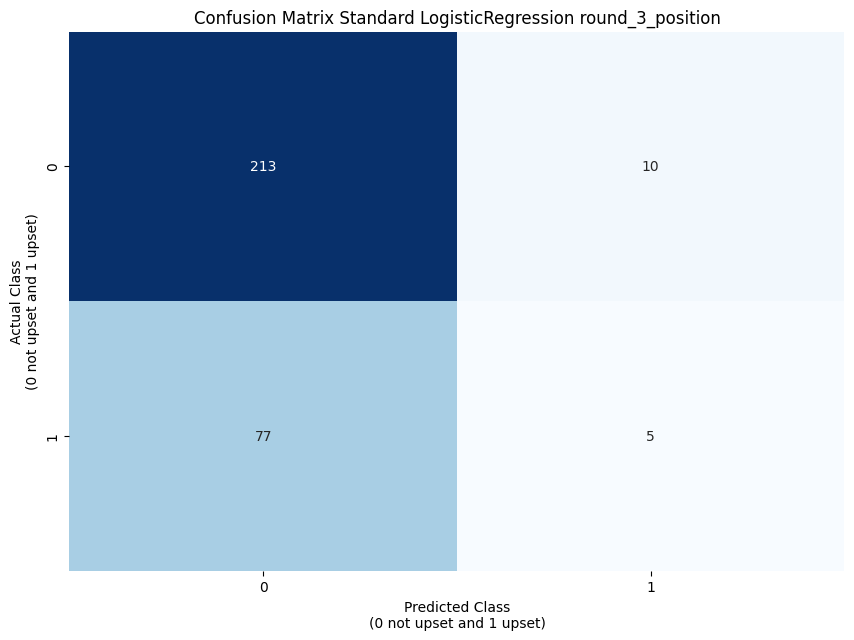

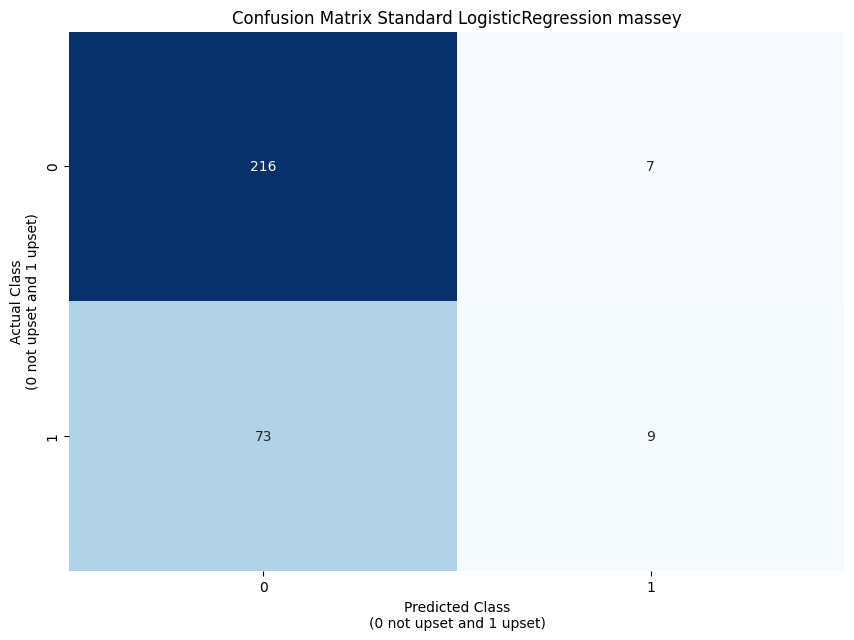

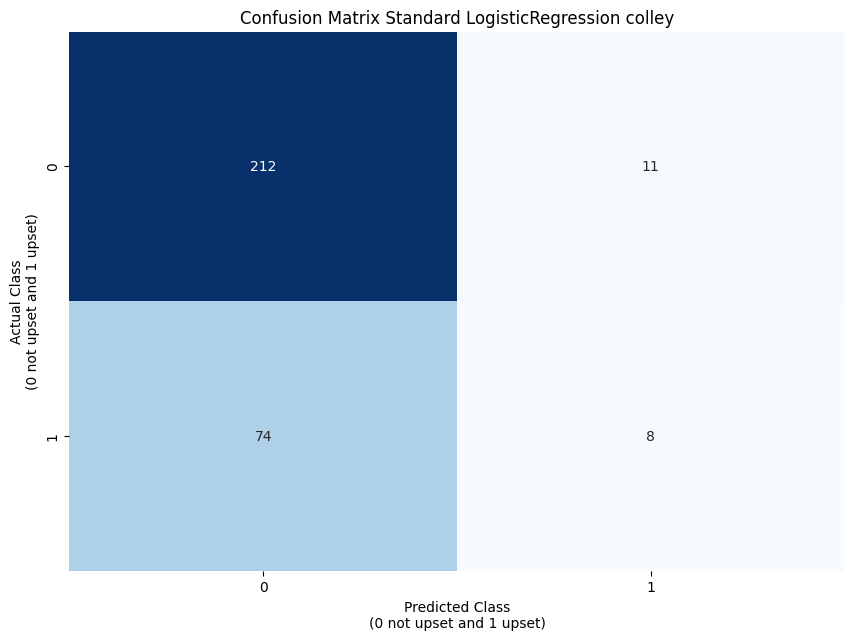

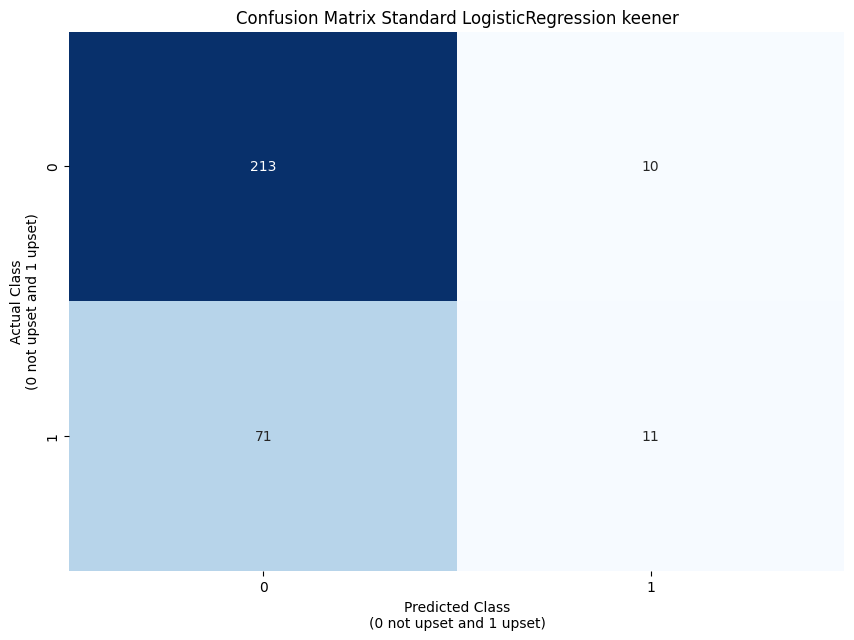

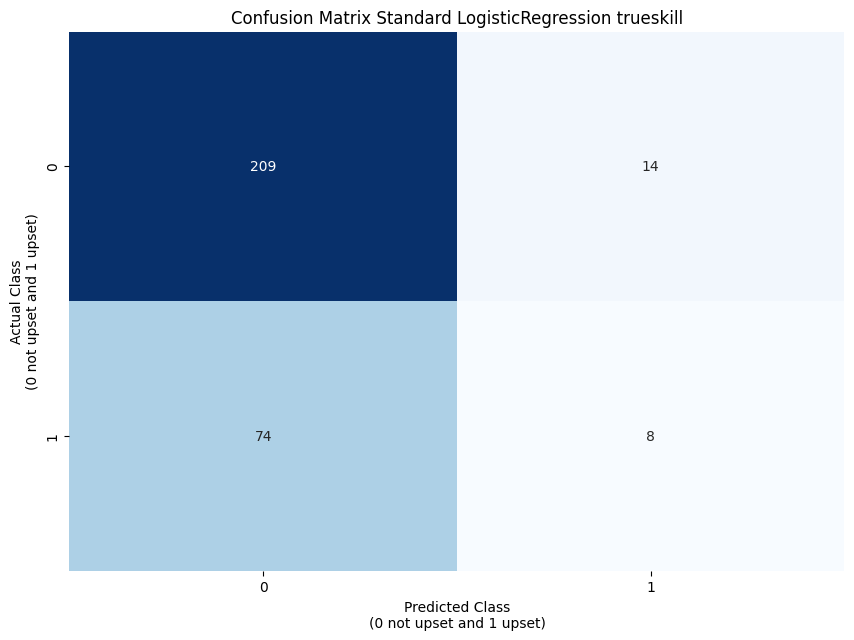

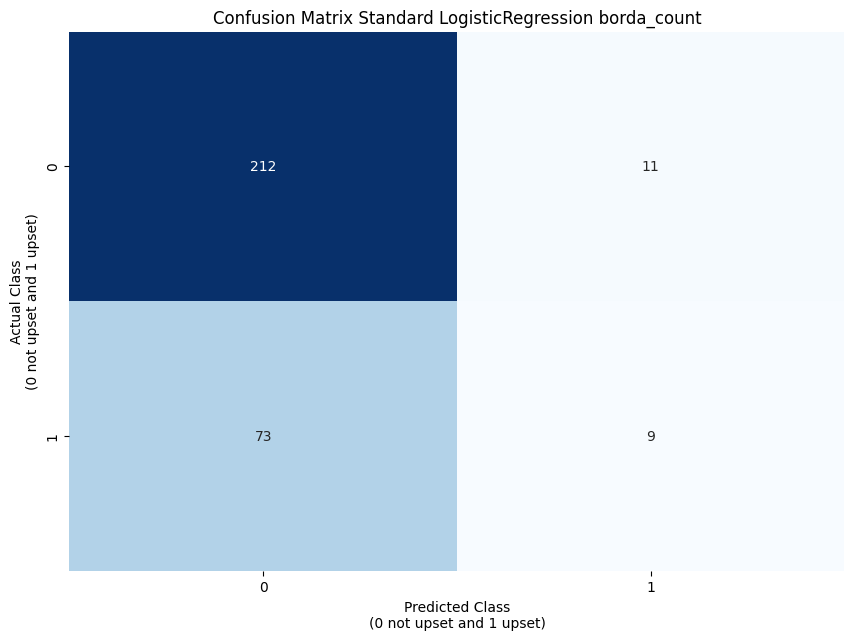

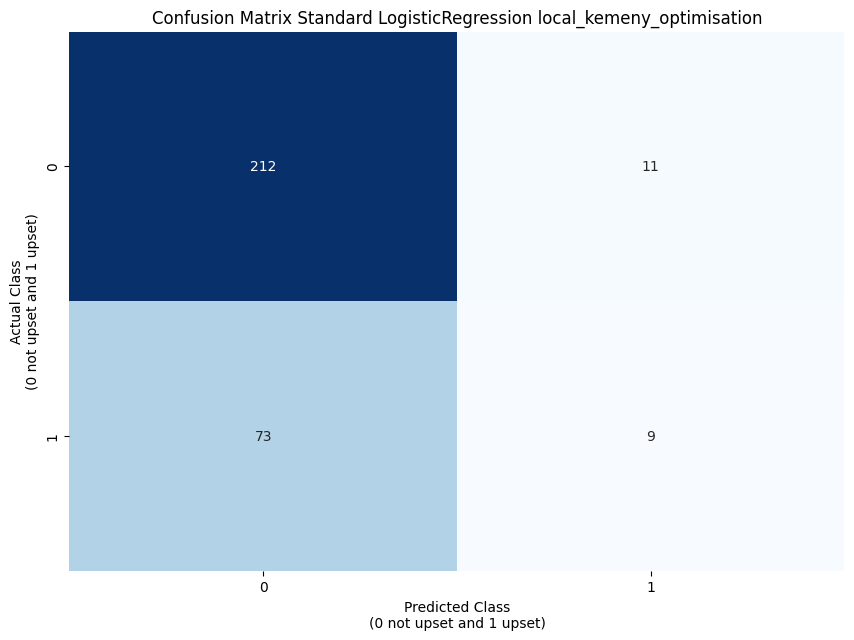

In [29]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Import user defined python functions
import model_evaluation_functions
importlib.reload(model_evaluation_functions)
from model_evaluation_functions import create_model_results_df
# Standard, no weights
model_name = "Standard LogisticRegression"
# Define the ranking systems
ranking_systems = ['round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

# Get all columns except the target and ranking columns
target_variable = 'target_variable'
base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]


# Identify numeric and categorical columns
numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ranking_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each ranking system
for ranking in ranking_systems:
    print(f"\nRunning model for {ranking} ranking system")
    model_name_ranking = f"{model_name} {ranking}"
    print(model_name_ranking)

    # Prepare the feature set for the current ranking system
    current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
    X = fa_cup_raw_features_df[current_features]
    y = fa_cup_raw_features_df['target_variable']

    # Update preprocessor with current features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            ('rank', ranking_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
        ], verbose_feature_names_out=False)


    # Initialize lists to store results for each fold of the model
    fold_accuracies = []
    confusion_matrices = []
    classification_reports = []
    all_y_true = []
    all_y_pred = []

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Fit preprocessor and transform data
        X_train_preprocessed = preprocessor.fit_transform(X_train)
        X_val_preprocessed = preprocessor.transform(X_val)

        # Create pipeline
        model = Pipeline([
          ('preprocessor', preprocessor),
          ('classifier', LogisticRegression(max_iter=100))
          ])

        # Get feature names after preprocessing
        feature_names = preprocessor.get_feature_names_out()

        # Convert to DataFrame
        X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names, index=X_train.index)
        X_val_preprocessed_df = pd.DataFrame(X_val_preprocessed, columns=feature_names, index=X_val.index)

        # Simple check for missing values
        if X_train_preprocessed_df.isnull().values.any() or X_val_preprocessed_df.isnull().values.any():
          raise ValueError("Missing values found in preprocessed data. Please review your preprocessing steps.")

        print(f"\nFold {fold}")
        #print("Preprocessed Train data:")
        #display(pd.concat([X_train_preprocessed_df, y_train], axis=1))
        #print("\nPreprocessed Test data:")
        #display(pd.concat([X_val_preprocessed_df, y_val], axis=1))

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        fold_accuracies.append(accuracy)

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Generate classification report
        cr = classification_report(y_val, y_pred, output_dict=True)
        classification_reports.append(cr)

        # Store true and predicted values for later analysis
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

        print(f"Fold {fold} Accuracy: {accuracy:.3f}")

    # Calculate average accuracy
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Average Accuracy: {avg_accuracy:.3f}")

    # Create and display results using your existing function
    results_df_slr = create_model_results_df(all_y_true, all_y_pred, fold_accuracies, model_name_ranking)
    display(results_df_slr)



Running model for round_3_position ranking system
Standard LogisticRegression round_3_position

Fold 1
Fold 1 Accuracy: 0.721

Fold 2
Fold 2 Accuracy: 0.689

Fold 3
Fold 3 Accuracy: 0.721

Fold 4
Fold 4 Accuracy: 0.705

Fold 5
Fold 5 Accuracy: 0.738
Average Accuracy: 0.715


,metric,Standard LogisticRegression round_3_position
0,Cross-validation Accuracy,0.715
1,Overall Accuracy,0.715
2,Confusion Matrix - True Negative (Class 0),213.000
3,Confusion Matrix - False Positive (Class 1),10.000
4,Confusion Matrix - False Negative (Class 0),77.000
5,Confusion Matrix - True Positive (Class 1),5.000
6,Precision (Class 0),0.734
7,Recall (Class 0),0.955
8,F1-score (Class 0),0.830
9,Precision (Class 1),0.333



Running model for massey ranking system
Standard LogisticRegression massey

Fold 1
Fold 1 Accuracy: 0.754

Fold 2
Fold 2 Accuracy: 0.738

Fold 3
Fold 3 Accuracy: 0.738

Fold 4
Fold 4 Accuracy: 0.721

Fold 5
Fold 5 Accuracy: 0.738
Average Accuracy: 0.738


,metric,Standard LogisticRegression massey
0,Cross-validation Accuracy,0.738
1,Overall Accuracy,0.738
2,Confusion Matrix - True Negative (Class 0),216.000
3,Confusion Matrix - False Positive (Class 1),7.000
4,Confusion Matrix - False Negative (Class 0),73.000
5,Confusion Matrix - True Positive (Class 1),9.000
6,Precision (Class 0),0.747
7,Recall (Class 0),0.969
8,F1-score (Class 0),0.844
9,Precision (Class 1),0.562



Running model for colley ranking system
Standard LogisticRegression colley

Fold 1
Fold 1 Accuracy: 0.738

Fold 2
Fold 2 Accuracy: 0.689

Fold 3
Fold 3 Accuracy: 0.721

Fold 4
Fold 4 Accuracy: 0.754

Fold 5
Fold 5 Accuracy: 0.705
Average Accuracy: 0.721


,metric,Standard LogisticRegression colley
0,Cross-validation Accuracy,0.721
1,Overall Accuracy,0.721
2,Confusion Matrix - True Negative (Class 0),212.000
3,Confusion Matrix - False Positive (Class 1),11.000
4,Confusion Matrix - False Negative (Class 0),74.000
5,Confusion Matrix - True Positive (Class 1),8.000
6,Precision (Class 0),0.741
7,Recall (Class 0),0.951
8,F1-score (Class 0),0.833
9,Precision (Class 1),0.421



Running model for keener ranking system
Standard LogisticRegression keener

Fold 1
Fold 1 Accuracy: 0.738

Fold 2
Fold 2 Accuracy: 0.738

Fold 3
Fold 3 Accuracy: 0.705

Fold 4
Fold 4 Accuracy: 0.770

Fold 5
Fold 5 Accuracy: 0.721
Average Accuracy: 0.734


,metric,Standard LogisticRegression keener
0,Cross-validation Accuracy,0.734
1,Overall Accuracy,0.734
2,Confusion Matrix - True Negative (Class 0),213.000
3,Confusion Matrix - False Positive (Class 1),10.000
4,Confusion Matrix - False Negative (Class 0),71.000
5,Confusion Matrix - True Positive (Class 1),11.000
6,Precision (Class 0),0.750
7,Recall (Class 0),0.955
8,F1-score (Class 0),0.840
9,Precision (Class 1),0.524



Running model for trueskill ranking system
Standard LogisticRegression trueskill

Fold 1
Fold 1 Accuracy: 0.738

Fold 2
Fold 2 Accuracy: 0.721

Fold 3
Fold 3 Accuracy: 0.656

Fold 4
Fold 4 Accuracy: 0.738

Fold 5
Fold 5 Accuracy: 0.705
Average Accuracy: 0.711


,metric,Standard LogisticRegression trueskill
0,Cross-validation Accuracy,0.711
1,Overall Accuracy,0.711
2,Confusion Matrix - True Negative (Class 0),209.000
3,Confusion Matrix - False Positive (Class 1),14.000
4,Confusion Matrix - False Negative (Class 0),74.000
5,Confusion Matrix - True Positive (Class 1),8.000
6,Precision (Class 0),0.739
7,Recall (Class 0),0.937
8,F1-score (Class 0),0.826
9,Precision (Class 1),0.364



Running model for borda_count ranking system
Standard LogisticRegression borda_count

Fold 1
Fold 1 Accuracy: 0.738

Fold 2
Fold 2 Accuracy: 0.721

Fold 3
Fold 3 Accuracy: 0.705

Fold 4
Fold 4 Accuracy: 0.738

Fold 5
Fold 5 Accuracy: 0.721
Average Accuracy: 0.725


,metric,Standard LogisticRegression borda_count
0,Cross-validation Accuracy,0.725
1,Overall Accuracy,0.725
2,Confusion Matrix - True Negative (Class 0),212.000
3,Confusion Matrix - False Positive (Class 1),11.000
4,Confusion Matrix - False Negative (Class 0),73.000
5,Confusion Matrix - True Positive (Class 1),9.000
6,Precision (Class 0),0.744
7,Recall (Class 0),0.951
8,F1-score (Class 0),0.835
9,Precision (Class 1),0.450



Running model for local_kemeny_optimisation ranking system
Standard LogisticRegression local_kemeny_optimisation

Fold 1
Fold 1 Accuracy: 0.738

Fold 2
Fold 2 Accuracy: 0.721

Fold 3
Fold 3 Accuracy: 0.705

Fold 4
Fold 4 Accuracy: 0.738

Fold 5
Fold 5 Accuracy: 0.721
Average Accuracy: 0.725


,metric,Standard LogisticRegression local_kemeny_optimisation
0,Cross-validation Accuracy,0.725
1,Overall Accuracy,0.725
2,Confusion Matrix - True Negative (Class 0),212.000
3,Confusion Matrix - False Positive (Class 1),11.000
4,Confusion Matrix - False Negative (Class 0),73.000
5,Confusion Matrix - True Positive (Class 1),9.000
6,Precision (Class 0),0.744
7,Recall (Class 0),0.951
8,F1-score (Class 0),0.835
9,Precision (Class 1),0.450


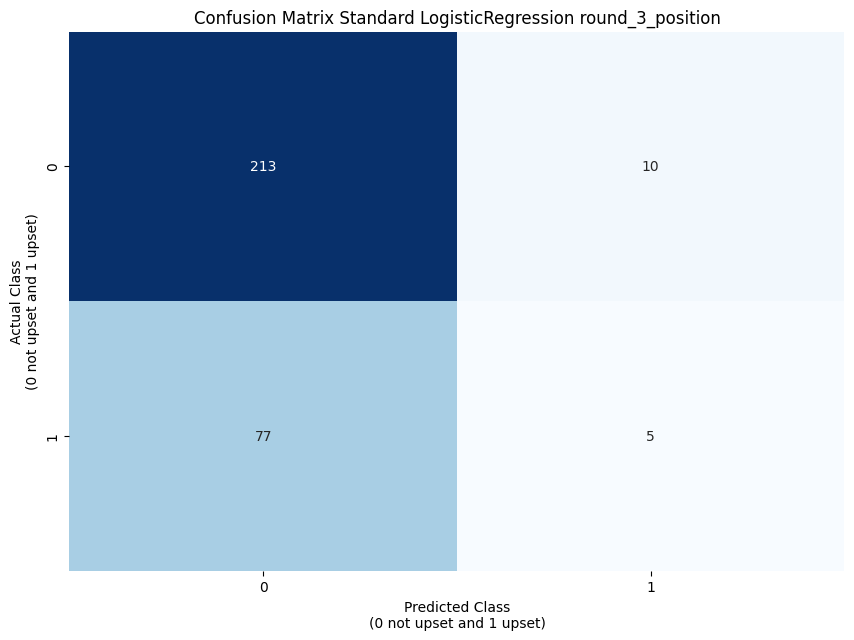

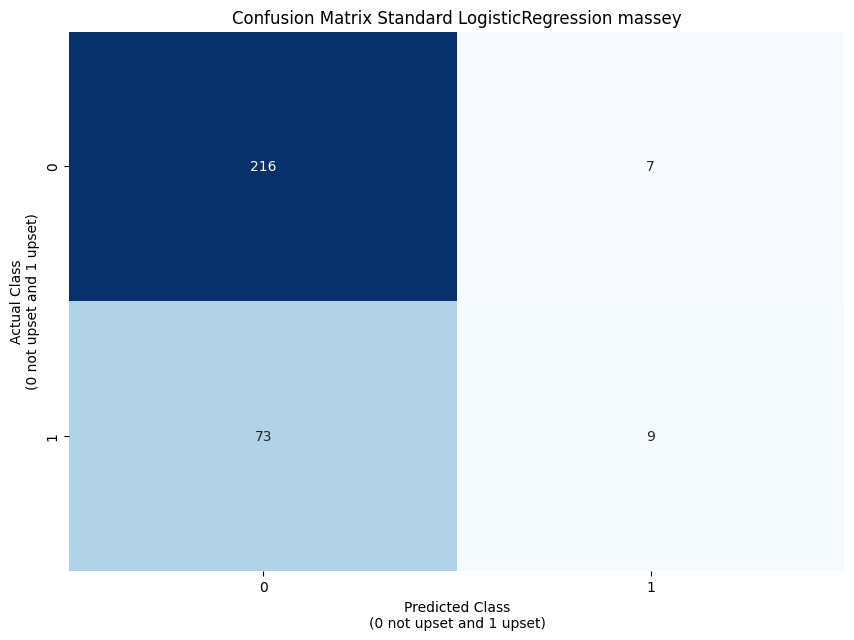

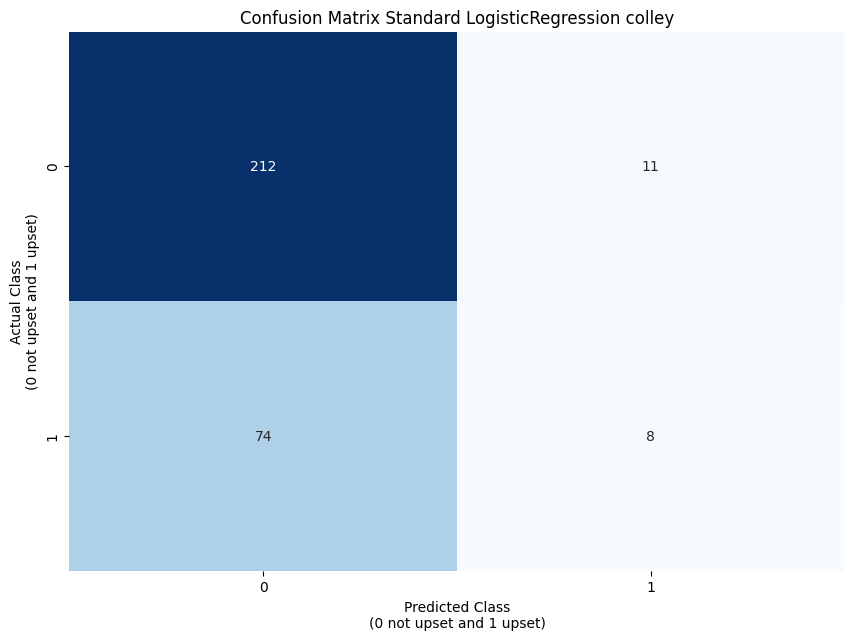

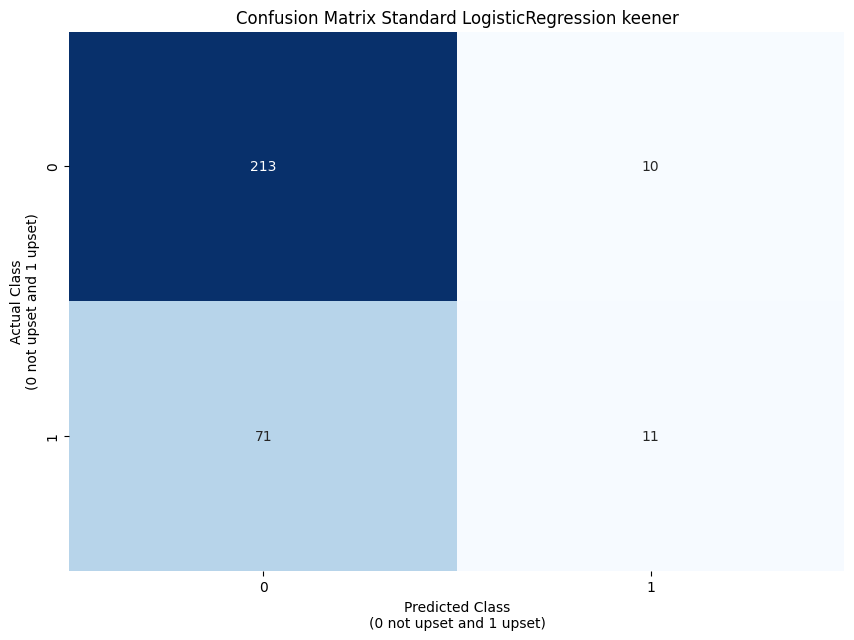

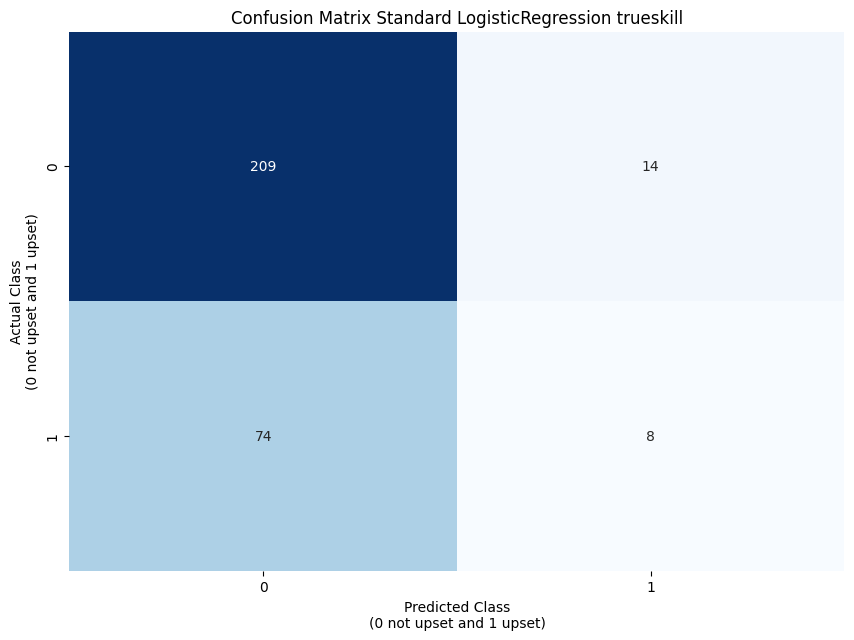

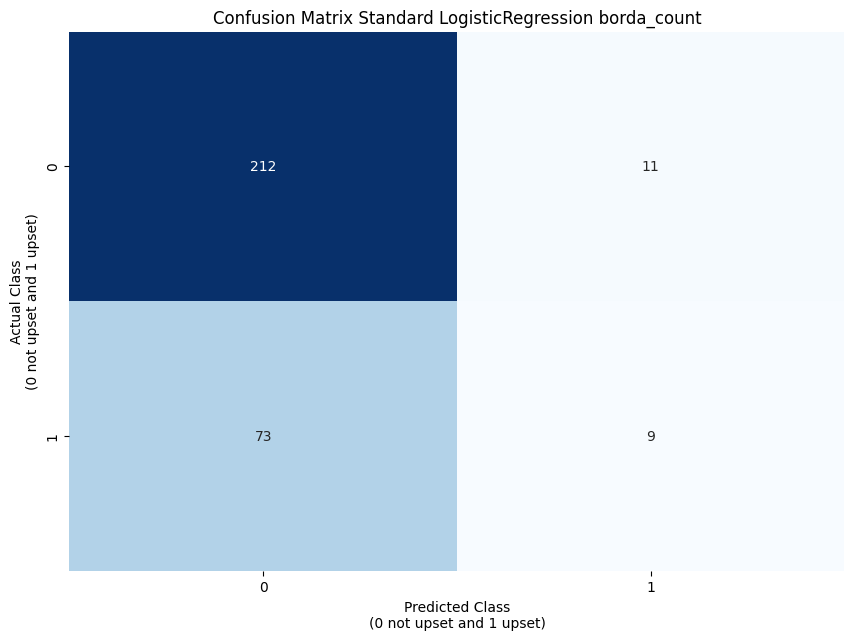

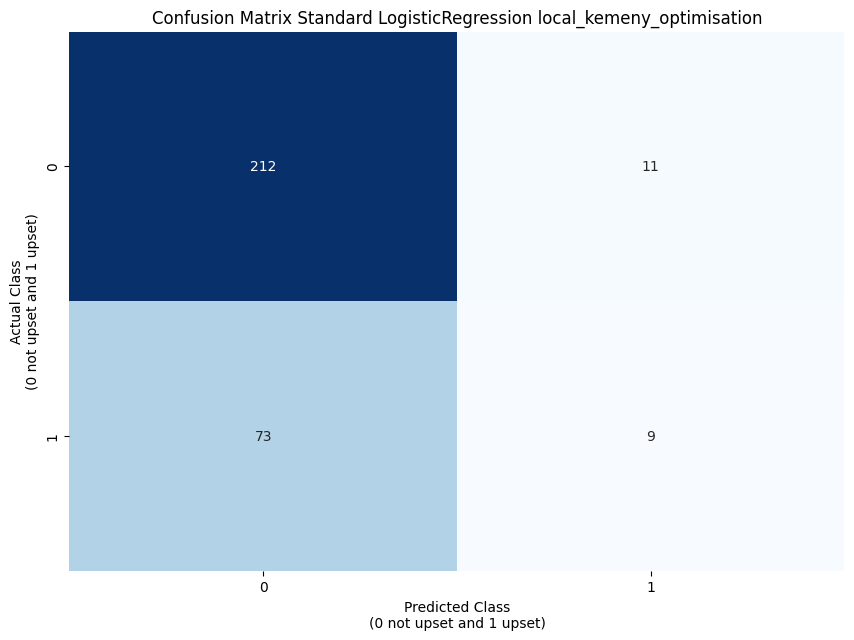

In [23]:
# Weighted Logistc Regression

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Import user defined python functions
import model_evaluation_functions
importlib.reload(model_evaluation_functions)
from model_evaluation_functions import create_model_results_df

# Standard, no weights
model_name = "Weighted LogisticRegression"

# Function to calculate weights
def calculate_weights(y):
    class_counts = y.value_counts()
    total_samples = len(y)
    return {class_label: int(round((1 - (count / total_samples)) * 100))
            for class_label, count in class_counts.items()}

# Define the ranking systems
ranking_systems = ['round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

# Get all columns except the target and ranking columns
target_variable = 'target_variable'
base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]


# Identify numeric and categorical columns
numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ranking_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each ranking system
for ranking in ranking_systems:
    print(f"\nRunning model for {ranking} ranking system")
    model_name_ranking = f"{model_name} {ranking}"
    print(model_name_ranking)

    # Prepare the feature set for the current ranking system
    current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
    X = fa_cup_raw_features_df[current_features]
    y = fa_cup_raw_features_df['target_variable']

    # Update preprocessor with current features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            ('rank', ranking_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
        ], verbose_feature_names_out=False)

    # Initialize lists to store results for each fold of the model
    fold_accuracies = []
    confusion_matrices = []
    classification_reports = []
    all_y_true = []
    all_y_pred = []

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Fit preprocessor and transform data
        X_train_preprocessed = preprocessor.fit_transform(X_train)
        X_val_preprocessed = preprocessor.transform(X_val)

        # Get feature names after preprocessing
        feature_names = preprocessor.get_feature_names_out()

        # Convert to DataFrame
        X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names, index=X_train.index)
        X_val_preprocessed_df = pd.DataFrame(X_val_preprocessed, columns=feature_names, index=X_val.index)

        # Calculate weights using only training data
        weights = calculate_weights(y_train)

        # Create pipeline
        model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(class_weight=weights,max_iter=1000))
        ])


        # Simple check for missing values
        if X_train_preprocessed_df.isnull().values.any() or X_val_preprocessed_df.isnull().values.any():
          raise ValueError("Missing values found in preprocessed data. Please review your preprocessing steps.")

        print(f"\nFold {fold}")
        #print("Preprocessed Train data:")
        #display(pd.concat([X_train_preprocessed_df, y_train], axis=1))
        #print("\nPreprocessed Test data:")
        #display(pd.concat([X_val_preprocessed_df, y_val], axis=1))

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        fold_accuracies.append(accuracy)

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Generate classification report
        cr = classification_report(y_val, y_pred, output_dict=True)
        classification_reports.append(cr)

        # Store true and predicted values for later analysis
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

        print(f"Fold {fold} Accuracy: {accuracy:.3f}")

    # Calculate average accuracy
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Average Accuracy: {avg_accuracy:.3f}")

    # Create and display results using your existing function
    results_df_slr = create_model_results_df(all_y_true, all_y_pred, fold_accuracies, model_name_ranking)
    display(results_df_slr)
